In [7]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

In [2]:
# setting hyperparameters
S = 10 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

In [3]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
(5000, 2, 2, 2)


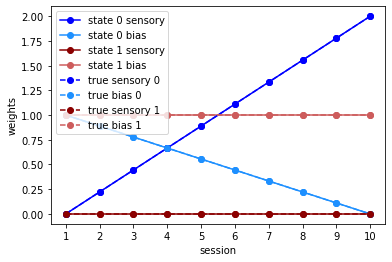

In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*1000)

print(trueW.shape)
plotting_weights(trueW, sessInd, trueW)

In [25]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

# _, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/N={N}_{K}_state_constant-drift_train')
#_, _, _= dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'../data/{K}_state_constant-drift_test') # test has size N=1000*10
trainX = np.load(f'../data/N={N}_{K}_state_constant-drift_trainX.npy')
trainY = np.load(f'../data/N={N}_{K}_state_constant-drift_trainY.npy')

In [6]:
ourSigma = np.zeros((2,2)) # k x d
ourSigma[0,0] = 0.11
ourSigma[0,1] = 0.22
ourSigma[1,0] = 0.01
ourSigma[1,1] = 0.01
oneSessInd = [0,N]

initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(trainX, trainY,  initP, initW, sigma=0, sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model
print(np.argmax(checkLl))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


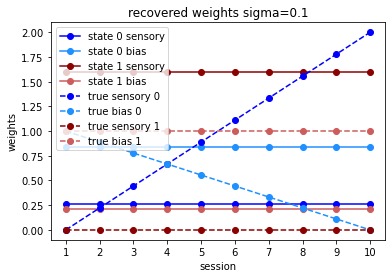

In [14]:
testX = np.load(f'../data/{K}_state_constant-drift_testX.npy')
testY = np.load(f'../data/{K}_state_constant-drift_testY.npy')
# testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(checkW[0], sessInd, testSessInd))
# _, _, testLl = dGLM_HMM.forward_pass(testY,checkP[0],testPhi)
# print("test LL per trial=", testLl/N/2)

plotting_weights(checkW, sessInd, trueW, 'recovered weights sigma=0.1')

In [7]:
ourSigma = np.zeros((2,2)) # k x d
ourSigma[0,0] = 0.11
ourSigma[0,1] = 0.22
ourSigma[1,0] = 0.01
ourSigma[1,1] = 0.01
inits = 20
checkP = np.empty((inits,K,K))
checkW = np.empty((inits,trainX.shape[0],K,D,C))
checkLl = np.empty((inits, 300))
for init in range(0,inits):
    initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
    checkP[init], checkW[init], checkLl[init] = dGLM_HMM.fit(trainX, trainY,  initP, initW, sigma=ourSigma, sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model
    print(np.argmax(checkLl))

np.save('../data/P_2_state_ourSigma', checkP)
np.save('../data/trainLl_2_state_ourSigma', checkLl)
np.save('../data/W_2_state_ourSigma', checkW)

5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180
5180


KeyboardInterrupt: 

In [15]:
checkP = np.load('../data/P_2_state_ourSigma.npy')
checkLl = np.load('../data/trainLl_2_state_ourSigma.npy')
checkW = np.load('../data/W_2_state_ourSigma.npy')

for init in range(8,13):
    testPhi = dGLM_HMM.observation_probability(testX, reshapeWeights(checkW[init], sessInd, testSessInd))
    _, _, testLl = dGLM_HMM.forward_pass(testY,checkP[init],testPhi)
    print("test LL per trial=", testLl/N/2)
    print(np.argmax(checkLl[init]))
    # plt.figure(figsize=(8,6))
    # plotting_weights(permute_states(checkW[init], sessInd), sessInd, trueW, f'recovered weights - init {init} ourSigma')

test LL per trial= -0.5955408777353932
299
test LL per trial= -0.5900529883350307
299
test LL per trial= -0.5901541637726203
299
test LL per trial= -0.591586768841785
299
test LL per trial= -0.5922191940984899
299


In [22]:
#Fitting for multiple values of Sigma 
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,-1,0.5,dtype=float))] + [2**x for x in list(np.arange(-1,8,1,dtype=float))]
allLl, allP, allW = fit_multiple_sigmas_simulated(N=N,K=K,D=D,C=C, sessInd=sessInd, sigmaList=sigmaList, inits=1, maxiter=300, modelType='constant-drift', save=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


[[0.98880916 0.01119084]
 [0.02800854 0.97199146]]


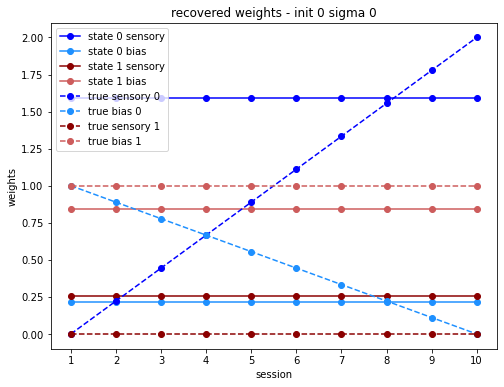

[[0.98857422 0.01142578]
 [0.02866375 0.97133625]]


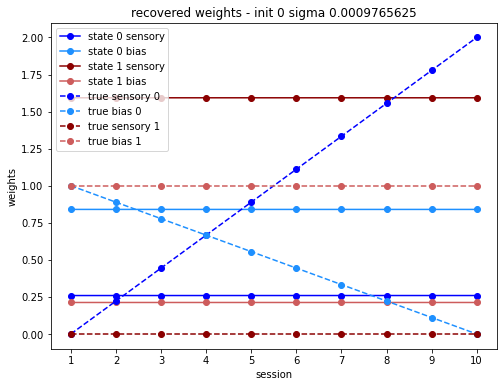

[[0.98855327 0.01144673]
 [0.02871268 0.97128732]]


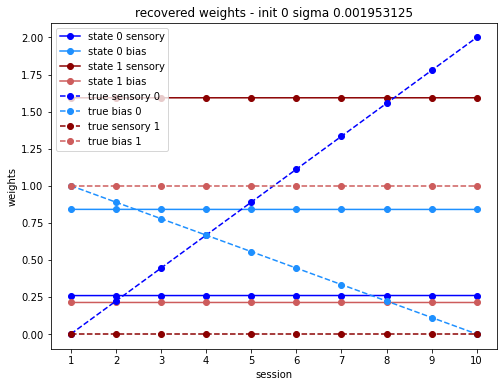

[[0.98853796 0.01146204]
 [0.02874902 0.97125098]]


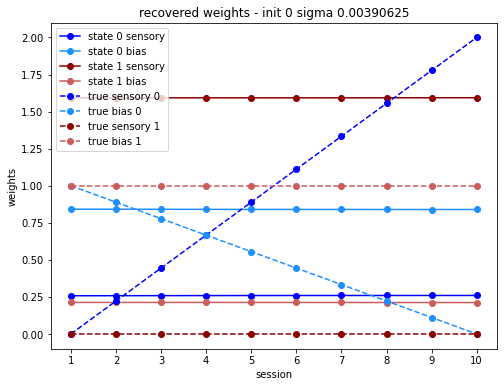

[[0.988476  0.011524 ]
 [0.0288929 0.9711071]]


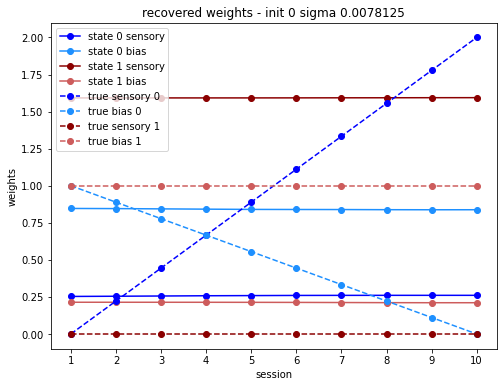

[[0.98831879 0.01168121]
 [0.02933543 0.97066457]]


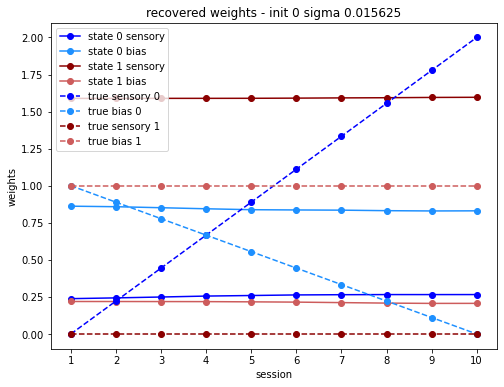

[[0.98845893 0.01154107]
 [0.02994104 0.97005896]]


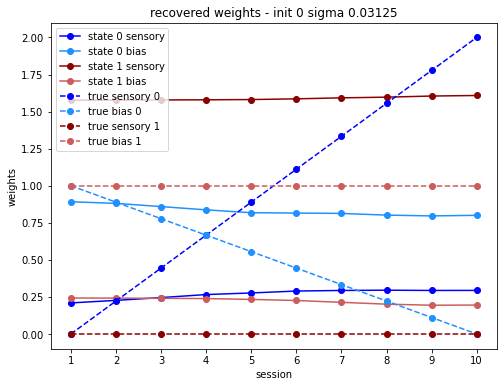

[[0.98809356 0.01190644]
 [0.03201453 0.96798547]]


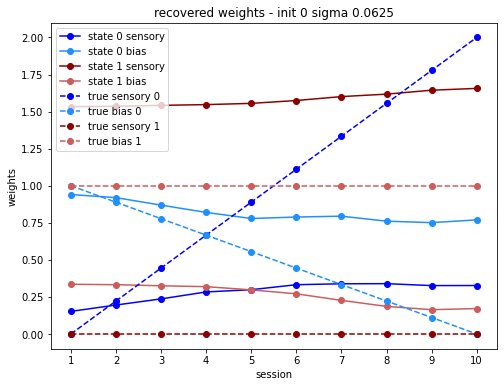

[[0.97009486 0.02990514]
 [0.03603116 0.96396884]]


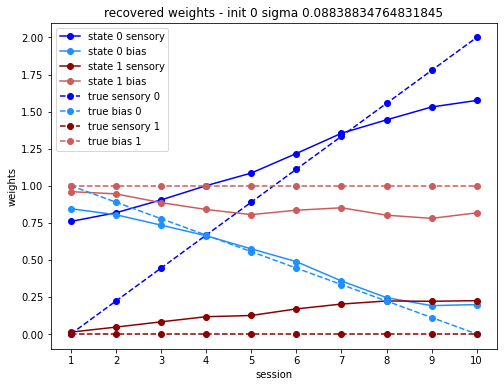

[[0.95712389 0.04287611]
 [0.03260186 0.96739814]]


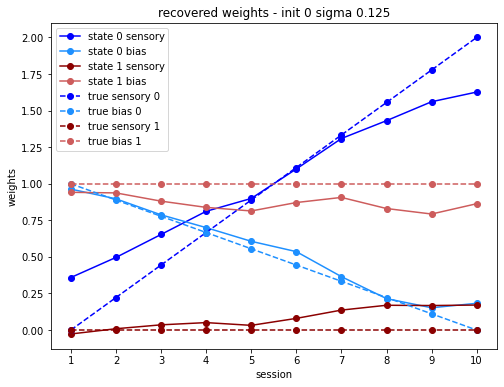

[[0.95534841 0.04465159]
 [0.0334386  0.9665614 ]]


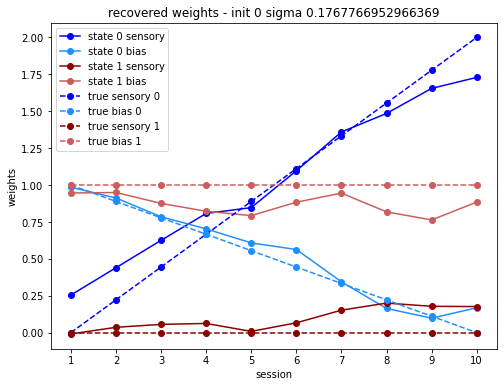

[[0.95440467 0.04559533]
 [0.03489154 0.96510846]]


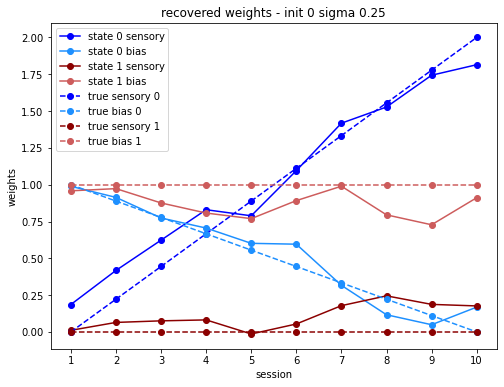

[[0.95155827 0.04844173]
 [0.0371349  0.9628651 ]]


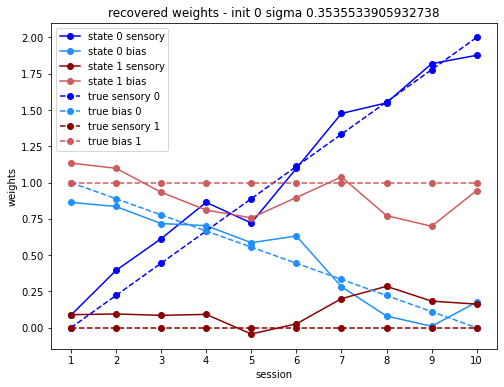

[[0.94956195 0.05043805]
 [0.03899524 0.96100476]]


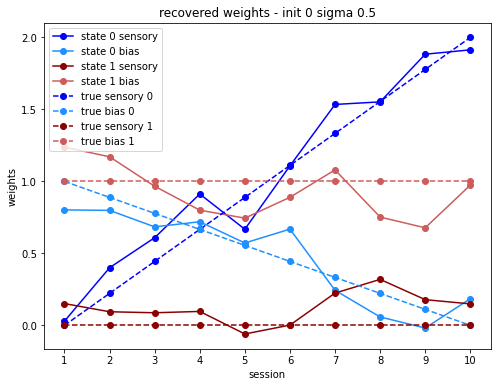

[[0.94484665 0.05515335]
 [0.04397149 0.95602851]]


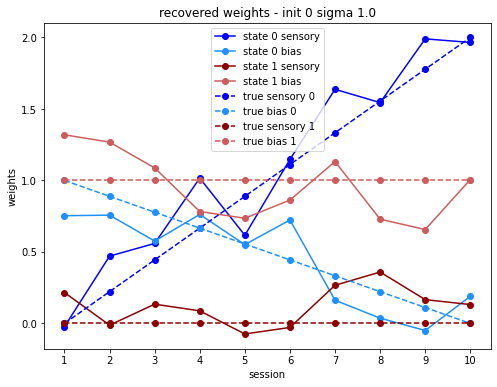

[[0.94240664 0.05759336]
 [0.04677455 0.95322545]]


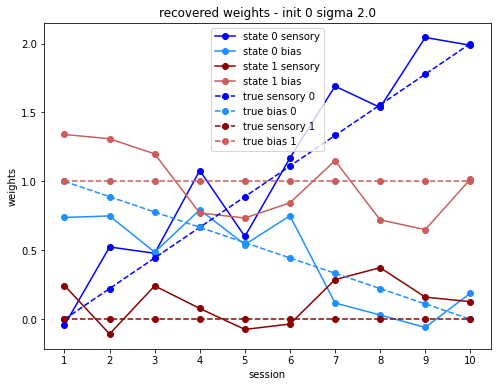

[[0.94168763 0.05831237]
 [0.04748188 0.95251812]]


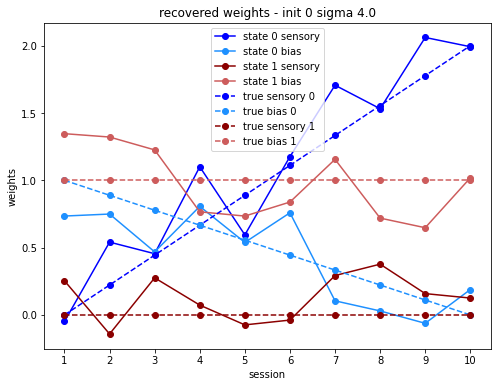

[[0.94112474 0.05887526]
 [0.04794628 0.95205372]]


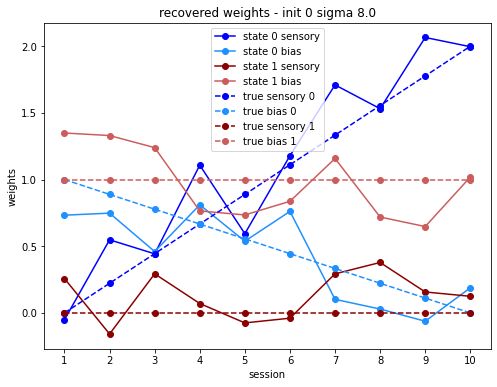

[[0.94063265 0.05936735]
 [0.04829091 0.95170909]]


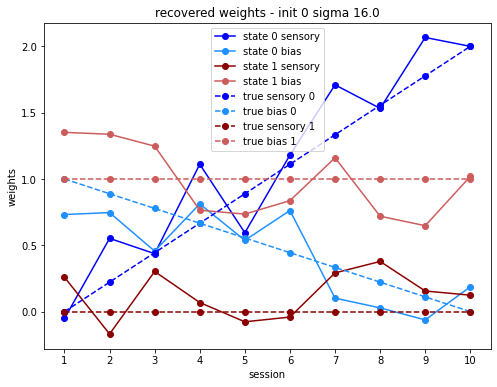

[[0.94023961 0.05976039]
 [0.04853263 0.95146737]]


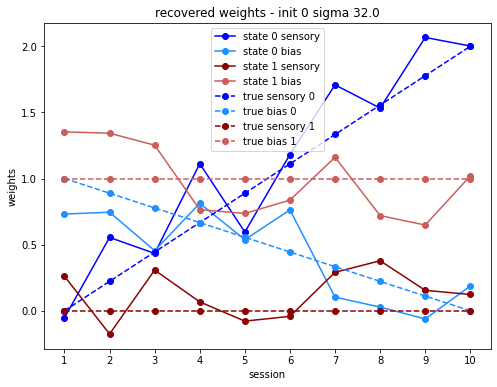

[[0.93994037 0.06005963]
 [0.04870065 0.95129935]]


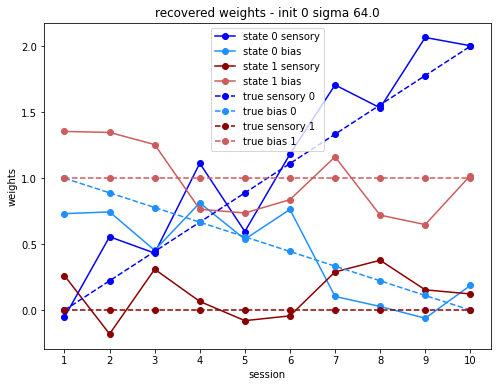

[[0.93971761 0.06028239]
 [0.04881812 0.95118188]]


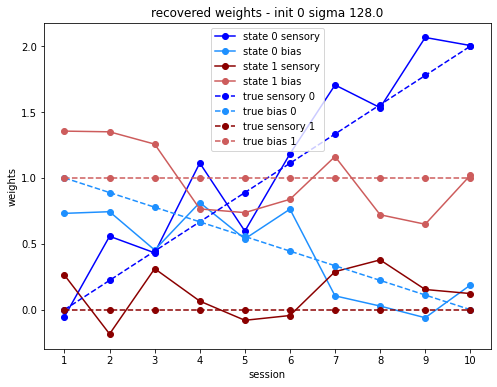

In [23]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,-1,0.5,dtype=float))] + [2**x for x in list(np.arange(-1,8,1,dtype=float))]
allW = np.load('../data//W_N=5000_2_state_constant-drift.npy')
allP = np.load('../data//P_N=5000_2_state_constant-drift.npy')
for init in range(0,1):
    for indSigma in range(0,len(sigmaList)): 
        #print(np.argmax(allLl[init,indSigma]))
        print(allP[init,indSigma])
        plt.figure(figsize=(8,6))
        plotting_weights(permute_states(allW[init, indSigma],sessInd), sessInd, trueW, f'recovered weights - init {init} sigma {sigmaList[indSigma]}')

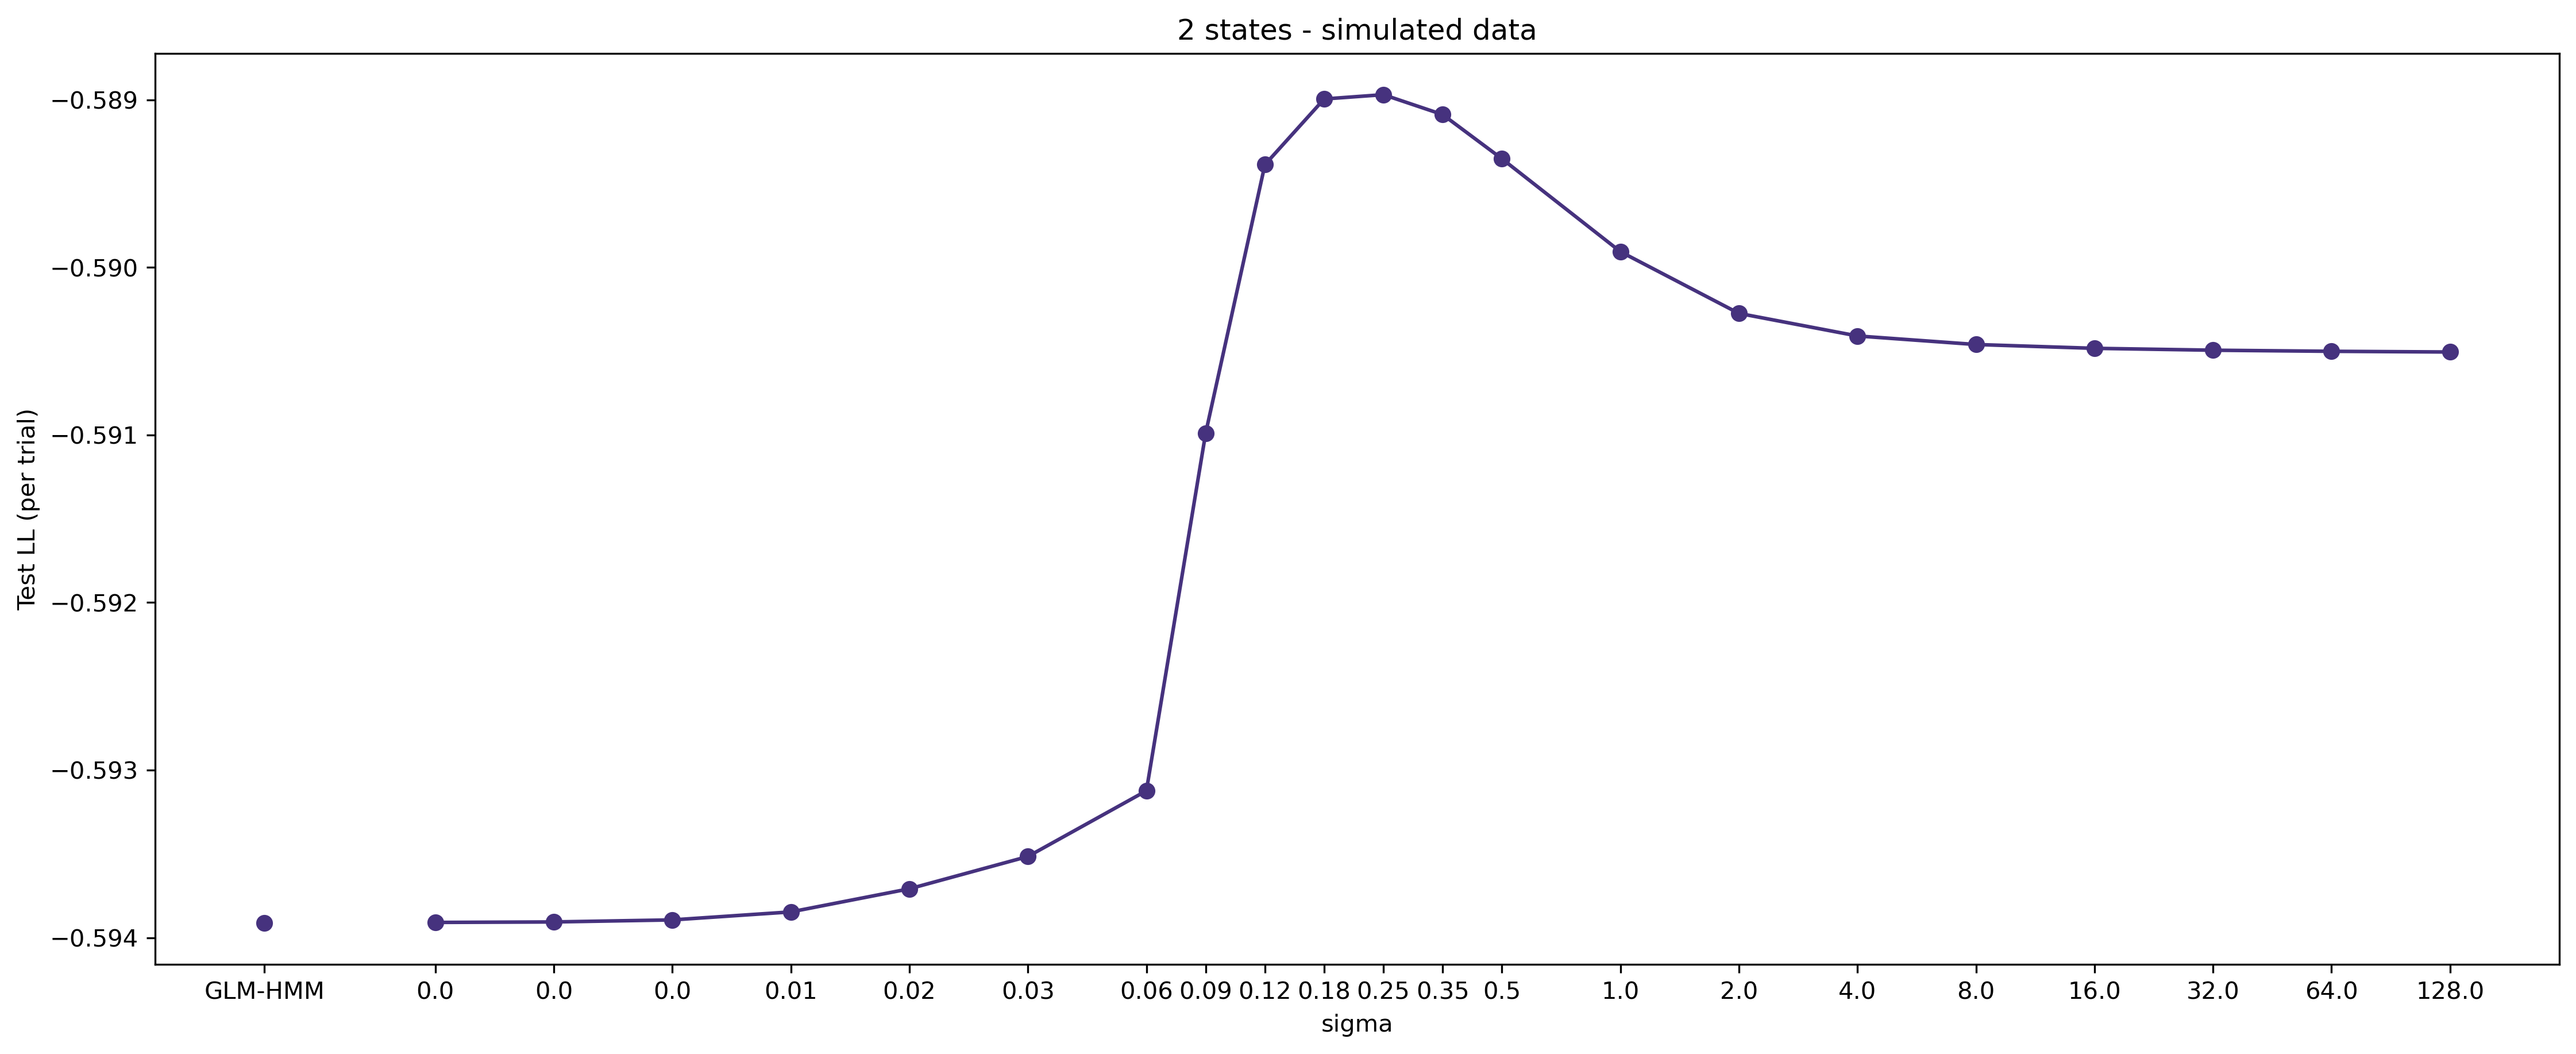

In [5]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,-1,0.5,dtype=float))] + [2**x for x in list(np.arange(-1,8,1,dtype=float))]
testLl = evaluate_multiple_sigmas_simulated(N,K,D,C, trainSessInd=sessInd, testSessInd=testSessInd, sigmaList = sigmaList, modelType='constant-drift', save=True)
    
fig, axes = plt.subplots(1, figsize = (18,7), dpi=300)
sigma_testLl_plot(sigmaList=sigmaList, testLl=testLl, axes=axes, title='2 states - simulated data', label='', save_fig=True)